In [14]:
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn.linear_model import LassoCV

In [15]:
# バージョンの確認
import numpy as np
print(np.__version__)
import scipy
print(scipy.__version__)
import sklearn
print(sklearn.__version__)

1.21.6
1.7.3
1.0.2


## Lassoの解パスの描写

lasso_pathにて解パスを求めます。

In [17]:
# 以下のコードを修正しました。
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

Computing regularization path using the lasso...


横軸が$-Log(alpha)$であることに注意します。

(-1.7693138817960326,
 0.7618191134343467,
 -14.902118474542556,
 28.553590194036772)

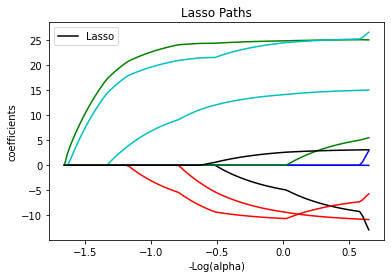

In [18]:
plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
l1[-1].set_label("Lasso")
plt.legend()
plt.axis("tight")

## LassoCVによる最適な正則化パラメータの探索

LassoCVにてクロスバリデーションで最適な正則化パラメータαを求めます。

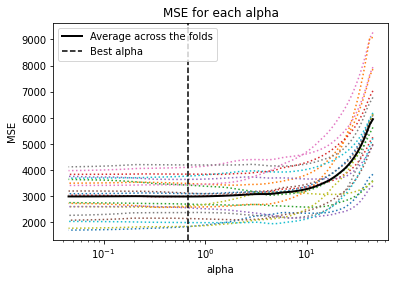

In [19]:
# 以下のコードを修正しました。
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py
# Author: Olivier Grisel
#         Gael Varoquaux
#         Alexandre Gramfort
#         Guillaume Lemaitre
# License: BSD 3 clause

# データの追加
rng = np.random.RandomState(42)
n_random_features = 14
X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f"random_{i:02d}" for i in range(n_random_features)],
)
X = pd.concat([X, X_random], axis=1)

lasso = LassoCV(cv=20, random_state=0).fit(X, y)
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

plt.axvline(lasso.alpha_, linestyle="--", color="black", label="Best alpha")

plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE for each alpha")

plt.legend()

MSEの平均が最小の正則化パラメータを取得していることが分かります。

In [20]:
print(f"Best Alpha (from model): {lasso.alpha_}")
print(f"Best Alpha (from MSE path): {lasso.alphas_[np.argmin(lasso.mse_path_.mean(axis=-1),)]}")

Best Alpha (from model): 0.6856153997937577
Best Alpha (from MSE path): 0.6856153997937577


MSEの標準誤差も加味して、１標準誤差ルールで正則化パラメータを選択することもできます。

まず各αにおけるMSEの標準誤差をエラーバーで表現してみます。

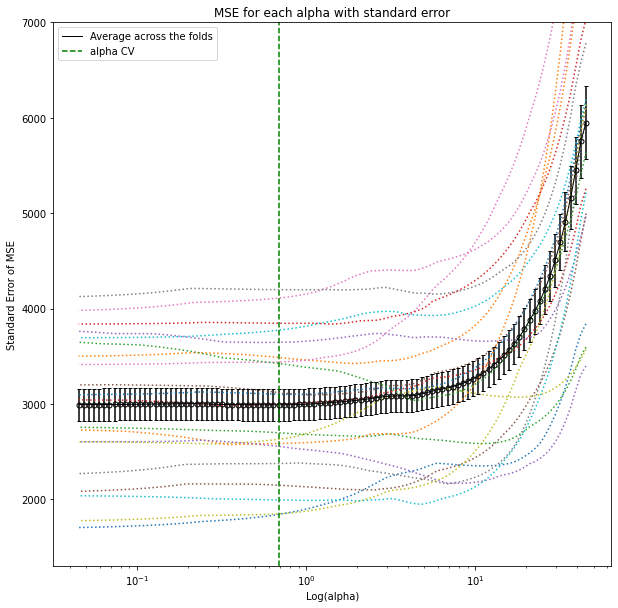

In [21]:
# ここはオリジナル

sem_err = [ sem(lasso.mse_path_[i,:]) for i in range(lasso.mse_path_.shape[0])]

plt.figure(figsize=(10,10))
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=1,
)
plt.errorbar(lasso.alphas_, lasso.mse_path_.mean(axis=-1), yerr = sem_err, capsize=2, fmt='o', ecolor='k', ms=5, mfc='None', mec='k')

plt.axvline(lasso.alpha_, linestyle="--", color="green", label="alpha CV")

plt.ylim([1300, 7000])
plt.xlabel("Log(alpha)")
plt.ylabel("Standard Error of MSE")
plt.title("MSE for each alpha with standard error")

plt.legend()

標準誤差が分かったので、CVが最小のMSE（これを$CV_0$とする）にそのときの標準誤差（これを$se_0$とする）を足した値を超えない範囲で、最大のMSEを取るαを選びます。

In [24]:
# CVで選んだ最適なalphaでのMSEの平均値とその標準誤差を調べる
best_alpha_idx = np.argmin(lasso.mse_path_.mean(axis=-1),)
se0 = sem_err[best_alpha_idx]
cv0 = lasso.mse_path_.mean(axis=-1)[best_alpha_idx]

# CV0+se0に収まる範囲の最大のMSE（の平均値）を取るalphaを求める
scores = lasso.mse_path_.mean(axis=-1)
scores = [score if score < cv0+se0 else -np.inf for score in scores]
alpha_one_standard_error_rule = lasso.alphas_[np.argmax(scores)]
print(f"Alpha: {alpha_one_standard_error_rule}")

Alpha: 5.963133101500133


先ほど書いたグラフに、１標準誤差ルールで求めたαも描いてみます。

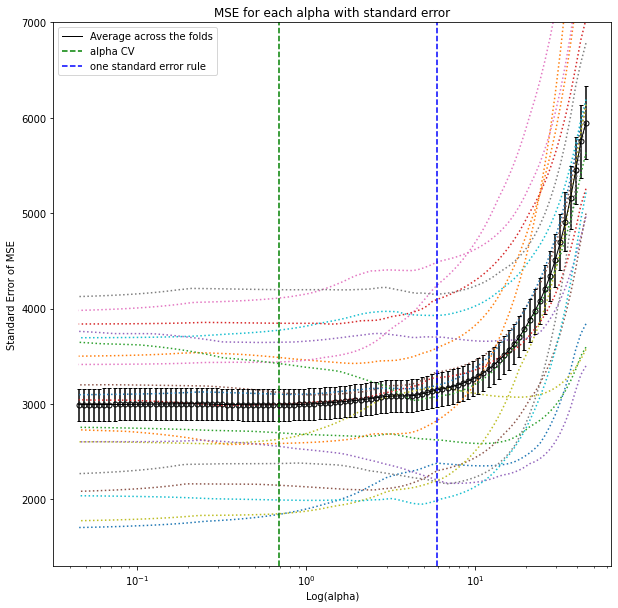

In [23]:
sem_err = [ sem(lasso.mse_path_[i,:]) for i in range(lasso.mse_path_.shape[0])]

plt.figure(figsize=(10,10))
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=1,
)
plt.errorbar(lasso.alphas_, lasso.mse_path_.mean(axis=-1), yerr = sem_err, capsize=2, fmt='o', ecolor='k', ms=5, mfc='None', mec='k')

plt.axvline(lasso.alpha_, linestyle="--", color="green", label="alpha CV")
plt.axvline(alpha_one_standard_error_rule, linestyle="--", color="blue", label="one standard error rule")

plt.ylim([1300, 7000])
plt.xlabel("Log(alpha)")
plt.ylabel("Standard Error of MSE")
plt.title("MSE for each alpha with standard error")

plt.legend()